# LaseNet Model Comparison: RNN vs. Transformer

This notebook trains and evaluates two architectures for latent variable estimation:
1.  **LaseNetRNN**: The original Bidirectional GRU model.
2.  **LaseNetTransformer**: An updated model using a Transformer encoder.

The workflow combines data loading, training, and evaluation into a single process for direct comparison of the two models.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- Local Imports ---
# Ensure models.py and feature_utils.py are in the correct paths
from models import LaseNetRNN, LaseNetTransformer
from utils.feature_utils import (
    get_onehot_features,
    get_feature_list_by_model,
    get_labels_by_model,
    CognitiveModel,
)

## 2. Configuration

In [2]:
# --- General Setup ---
RESULT_DIR = './results'
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
    
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# --- Data and Model Configuration ---
MODEL_TO_RUN = CognitiveModel.PRL4
DATA_FILE_PATH = f'../data/4prl/100a_720t.csv' # <-- SET YOUR DATA FILE PATH HERE
TARGET_VARIABLE = ['rpe_history'] # The latent variable you want to predict



Using device: cuda


## 3. Data Loading and Preprocessing

In [3]:
data = pd.read_csv(DATA_FILE_PATH)

# Extract features and labels
features = get_onehot_features(data, get_feature_list_by_model(MODEL_TO_RUN))
labels = get_labels_by_model(data, MODEL_TO_RUN)

# Use agent IDs for robust splitting
agent_ids = data['agentid'].unique()
train_val_agents, test_agents = train_test_split(agent_ids, test_size=0.2, random_state=42)
train_agents, val_agents = train_test_split(train_val_agents, test_size=0.15, random_state=42)

# Create data splits based on agent IDs
train_indices = np.where(np.isin(data['agentid'].unique(), train_agents))[0]
val_indices = np.where(np.isin(data['agentid'].unique(), val_agents))[0]
test_indices = np.where(np.isin(data['agentid'].unique(), test_agents))[0]

X_train, X_val, X_test = features[train_indices], features[val_indices], features[test_indices]
y_train, y_val, y_test = labels[train_indices], labels[val_indices], labels[test_indices]

print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Val shapes:   X={X_val.shape}, y={y_val.shape}")
print(f"Test shapes:  X={X_test.shape}, y={y_test.shape}")

Train shapes: X=torch.Size([68, 720, 4]), y=(68, 720)
Val shapes:   X=torch.Size([12, 720, 4]), y=(12, 720)
Test shapes:  X=torch.Size([20, 720, 4]), y=(20, 720)


## 4. Model Training

In [6]:
dropout = 0.07 
dropout1 = 0.053 
dropout2 =  0.014 
# --- Training Hyperparameters ---
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 200
EARLY_STOPPING_PATIENCE = 35

In [11]:
# Convert data to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# Create DataLoader for training
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

def train_model(model, model_name):
    """Generic training loop with a learning rate scheduler."""
    print(f"\n--- Training {model_name} Model ---")
    model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # --- LEARNING RATE SCHEDULER SETUP ---
    warmup_epochs = 5
    total_steps = len(train_loader) * EPOCHS
    
    def lr_lambda(current_step):
        # Linear warm-up for the first few epochs
        if current_step < len(train_loader) * warmup_epochs:
            return float(current_step) / (len(train_loader) * warmup_epochs)
        # Linear decay after warm-up
        return max(0.0, float(total_steps - current_step) / float(total_steps - len(train_loader) * warmup_epochs))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    # --- END SCHEDULER SETUP ---

    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    
    best_val_loss = float('inf')
    patience_counter = 0

    start_time = time.time()
    for epoch in tqdm(range(EPOCHS), desc=f'{model_name} Epochs'):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X_batch)
            
            if isinstance(outputs, dict):
                outputs = outputs['continuous_latent']

            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            # Step the scheduler after each batch
            scheduler.step()
            
            epoch_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_t.to(DEVICE))
            if isinstance(val_outputs, dict):
                val_outputs = val_outputs['continuous_latent']
            val_loss = criterion(val_outputs, y_val_t.to(DEVICE)).item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'{RESULT_DIR}/{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    end_time = time.time()
    print(f"Training finished in {end_time - start_time:.2f} seconds.")
    return history

C:\Users\ijiny\AppData\Local\Temp\ipykernel_27880\210965958.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_t = torch.tensor(X_train, dtype=torch.float32)
C:\Users\ijiny\AppData\Local\Temp\ipykernel_27880\210965958.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_t = torch.tensor(X_val, dtype=torch.float32)
C:\Users\ijiny\AppData\Local\Temp\ipykernel_27880\210965958.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_t = torch.tensor(X_test, dtype=torch.float32)


In [12]:
# Initialize and train both models
feature_dim = X_train.shape[-1]
output_dim = 1

rnn_model = LaseNetRNN(feature_dim, continuous_output_dim=output_dim, dropout=dropout,
    dropout1=dropout1,
    dropout2=dropout2)
transformer_model = LaseNetTransformer(feature_dim, continuous_output_dim=output_dim)

rnn_history = train_model(rnn_model, 'RNN')
transformer_history = train_model(transformer_model, 'Transformer')


--- Training RNN Model ---


RNN Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training finished in 16.49 seconds.

--- Training Transformer Model ---


Transformer Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping triggered at epoch 195
Training finished in 22.12 seconds.


## 5. Evaluation and Comparison

In [13]:
# Load best models for final evaluation
rnn_model.load_state_dict(torch.load(f'{RESULT_DIR}/RNN_best_model.pth'))
transformer_model.load_state_dict(torch.load(f'{RESULT_DIR}/Transformer_best_model.pth'))

rnn_model.to(DEVICE).eval()
transformer_model.to(DEVICE).eval()

# Make predictions on the test set
with torch.no_grad():
    y_pred_rnn = rnn_model(X_test_t.to(DEVICE)).cpu().numpy()
    y_pred_transformer = transformer_model(X_test_t.to(DEVICE)).cpu().numpy()

# Flatten results for metric calculations
y_test_flat = y_test.flatten()
y_pred_rnn_flat = y_pred_rnn.flatten()
y_pred_transformer_flat = y_pred_transformer.flatten()

# Calculate Metrics
mse_rnn = mean_squared_error(y_test_flat, y_pred_rnn_flat)
r2_rnn = r2_score(y_test_flat, y_pred_rnn_flat)

mse_transformer = mean_squared_error(y_test_flat, y_pred_transformer_flat)
r2_transformer = r2_score(y_test_flat, y_pred_transformer_flat)

print("--- Performance on Test Set ---")
print(f"RNN Model         -> MSE: {mse_rnn:.4f}, R-squared: {r2_rnn:.4f}")
print(f"Transformer Model -> MSE: {mse_transformer:.4f}, R-squared: {r2_transformer:.4f}")

--- Performance on Test Set ---
RNN Model         -> MSE: 0.0828, R-squared: 0.0213
Transformer Model -> MSE: 0.0839, R-squared: 0.0087


### Visual Comparison

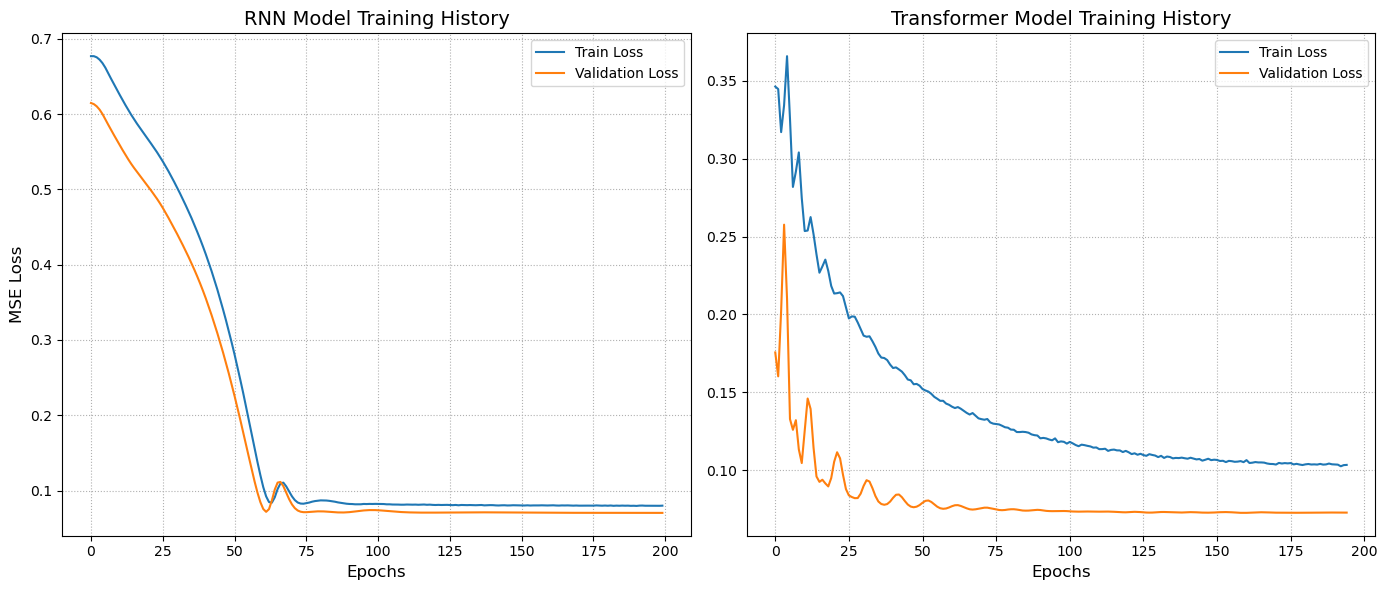

In [14]:
# 1. Plot Training History
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
rnn_hist_df = pd.DataFrame(rnn_history)
plt.plot(rnn_hist_df['train_loss'], label='Train Loss')
plt.plot(rnn_hist_df['val_loss'], label='Validation Loss')
plt.title('RNN Model Training History', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')

plt.subplot(1, 2, 2)
transformer_hist_df = pd.DataFrame(transformer_history)
plt.plot(transformer_hist_df['train_loss'], label='Train Loss')
plt.plot(transformer_hist_df['val_loss'], label='Validation Loss')
plt.title('Transformer Model Training History', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')

plt.tight_layout()
plt.savefig(f'{RESULT_DIR}/training_history_comparison.png')
plt.show()

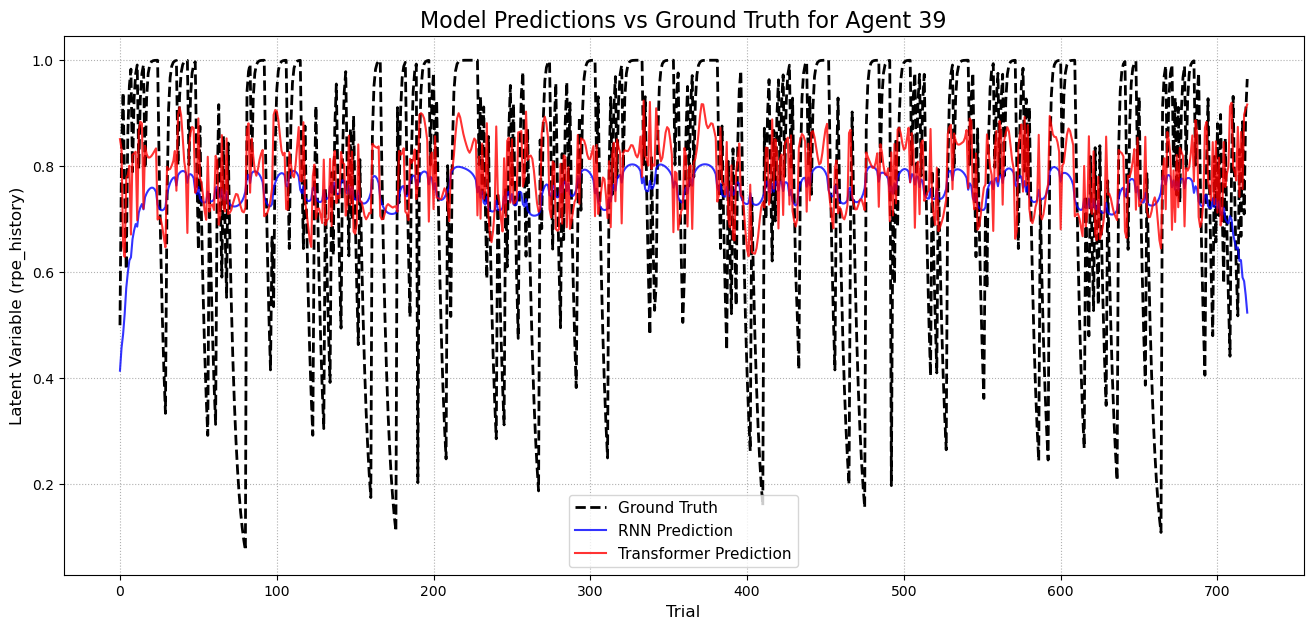

In [15]:
# 2. Plot Predictions vs. Actual for a sample agent
agent_idx_to_plot = 5
plt.figure(figsize=(16, 7))

plt.plot(y_test[agent_idx_to_plot, :], label='Ground Truth', color='black', linestyle='--', linewidth=2)
plt.plot(y_pred_rnn[agent_idx_to_plot, :], label=f'RNN Prediction', color='blue', alpha=0.8)
plt.plot(y_pred_transformer[agent_idx_to_plot, :], label=f'Transformer Prediction', color='red', alpha=0.8)

plt.title(f'Model Predictions vs Ground Truth for Agent {test_agents[agent_idx_to_plot]}', fontsize=16)
plt.xlabel('Trial', fontsize=12)
plt.ylabel(f'Latent Variable ({TARGET_VARIABLE[0]})', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle=':')
plt.savefig(f'{RESULT_DIR}/prediction_comparison_agent_{test_agents[agent_idx_to_plot]}.png')
plt.show()

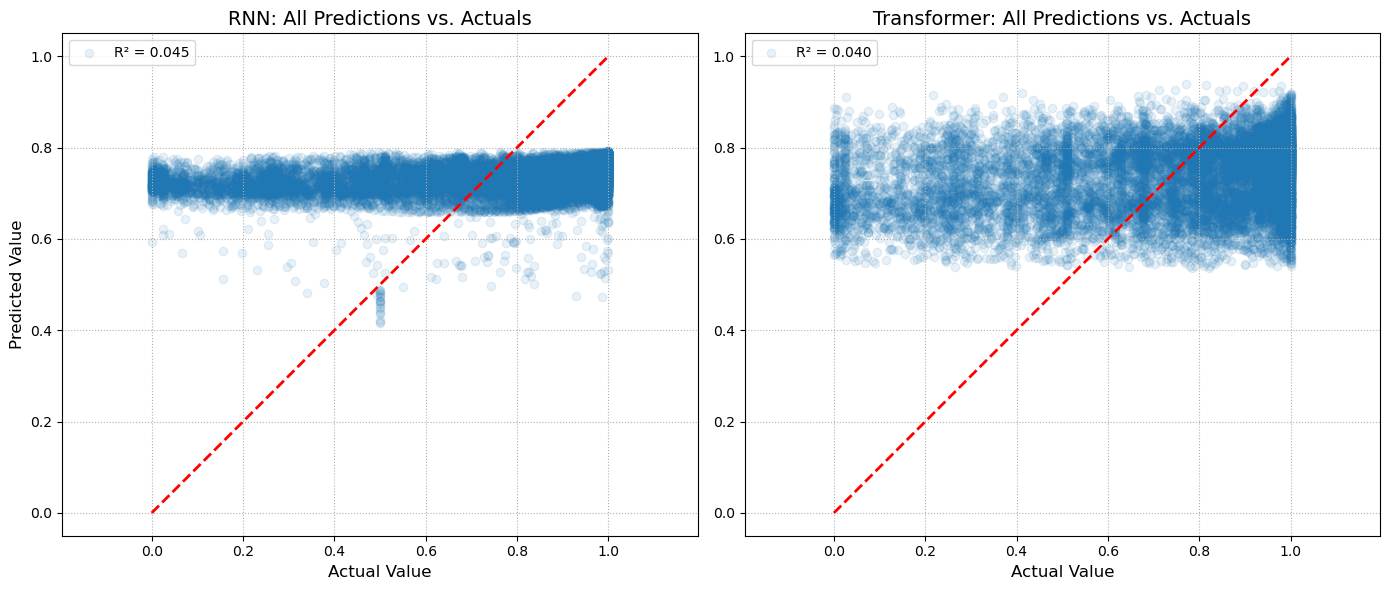

In [ ]:
# 3. Scatter plot of all test predictions vs actuals
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_flat, y_pred_rnn_flat, alpha=0.1, label=f'R² = {r2_rnn:.3f}')
plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], 'r--', linewidth=2)
plt.title('RNN: All Predictions vs. Actuals', fontsize=14)
plt.xlabel('Actual Value', fontsize=12)
plt.ylabel('Predicted Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(y_test_flat, y_pred_transformer_flat, alpha=0.1, label=f'R² = {r2_transformer:.3f}')
plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], 'r--', linewidth=2)
plt.title('Transformer: All Predictions vs. Actuals', fontsize=14)
plt.xlabel('Actual Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')
plt.axis('equal')
plt.tight_layout()
plt.savefig(f'{RESULT_DIR}/scatter_comparison.png')
plt.show()